In this notebook, we are goin to compute wavelet time-frequency spectrograms for events, baselined to other epochs (e.g. fixation crosses) from the task. We are also going to focus on saving the data out in an efficient matter for subsequent analysis

Update (5/8/2024): We now remove IEDs and artifacts from the data **after** computing the TFR.

In an ideal world (e.g. infinite data) we would just remove trials that have IEDs and artifacts. This is because even the inclusion of these data in the TFR computation probably causes some spread of noise to nearby timepoints and frequencies. 

However, we don't have infinite data, so cannot be tossing trials so casually. So instead, we compute the TFR and THEN NaN out the timepoints that we know to be likely IEDs and artifacts, so they don't contribute to plots and statistics performed downstream. 

Also, IED and artifact detection occurs in the raw data. After baselining data, we can sometimes get artifactually high z-scores (ranging from z=10-500). This is usually a very small amount of the data (~< 1%) but are huge outliers for downstream analysis. So we just NaN those out as well. 



In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import mne
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
import pandas as pd
import os 
import joblib
import pickle
from tqdm import tqdm
from IPython.display import clear_output
import warnings 
from ast import literal_eval


# I only want to see warnings once
warnings.filterwarnings('ignore')

from joblib import delayed, Parallel
from statsmodels.stats import multitest

In [4]:
# Set some plot defaults for matplotlib (when not using seaborn): 

import  matplotlib.font_manager

path = '/sc/arion/projects/guLab/Salman/Arial.ttf'
matplotlib.font_manager.fontManager.addfont(path)

prop = matplotlib.font_manager.FontProperties(fname=path)

# Set the default font family to the registered custom font
plt.rcParams['font.family'] = prop.get_name()

# Rest of your customization code
plt.rcParams['font.size'] = 20
plt.rcParams['lines.linewidth'] = 1



Note: If you have installed this package in editable form on Minerva, you must append the local path! This is because Minerva requires that you point your package installs away from the local directory for space reasons, but editable packages have to be installed locally.

In [5]:
import sys
sys.path.append('/hpc/users/qasims01/resources/LFPAnalysis')

In [6]:
from LFPAnalysis import lfp_preprocess_utils, sync_utils, analysis_utils, nlx_utils, oscillation_utils, statistics_utils


## First, get the behavior data

This is from another notebook with a kernel and environment specifically for beahvior

In [7]:
base_dir = '/sc/arion' # this is the root directory for most un-archived data and results
load_dir = f'{base_dir}/work/qasims01/MemoryBanditData/EMU'

# Load the demographics data to get information about who has run the task
demo_file = f'{base_dir}/projects/guLab/Salman/EMU/MemoryBanditsDatabase.xlsx'
demo_data = pd.read_excel(demo_file, engine='openpyxl')
subj_df = demo_data[(demo_data.LongVersion==1) & (demo_data.Minerva==1)]

# Let's get rid of Iowa patients for now 

# subj_df = subj_df[subj_df.Site=='UI']
subj_df = subj_df[~subj_df['MSSMCode'].isin(['UI002', 'MS024', 'MS034', 'MS038'])]

days = ['Day1', 'Day2']
subj_ids = subj_df.MSSMCode.values
subj_formats = subj_df.format.values
subj_sites = subj_df.Site.values
subj_days = subj_df.Day2.values

In [8]:
# load behavioral data
learn_df = pd.read_csv(f'{load_dir}/learn_df_RWH.csv')
combined_df = pd.read_csv(f'{load_dir}/full_df_RWH.csv')

# Filter just to the participants in this notebook
learn_df = learn_df[learn_df.participant.isin(subj_ids)]
combined_df = combined_df[combined_df.participant.isin(subj_ids)]


# I enter the day information in stupidly 
combined_df.condition = combined_df.condition.apply(lambda x: 'Day1' if x=='day_1' else 'Day2' if x=='day_2' else np.nan)
combined_df['recog_time'] = combined_df['recog_time'].apply(lambda x: float(x) if (~pd.isna(x)) & (x!='None') else x)
combined_df['baseline_start_mem'] = combined_df['baseline_start_y'].apply(lambda x: float(x) if (~pd.isna(x)) & (x!='None') else x)

# # add RPE to the combined df dataframe: 

# combined_df['rpe'] = np.nan
# for ix, row in learn_df.iterrows():
#     combined_df.loc[(combined_df.img_path==row.img_path) & (combined_df.participant==row.participant), 'rpe'] = row.rpe


## Wavelet TFRs

In order to compute event-locked time-frequency spectrograms, we need to first compute them for the baseline of interest (usually a fixation cross) and then for the events of interest (usually a patient choice epoch). 



In [9]:
# Explicitly define a list of analysis events and the baseline event. Should correspond to the dict

evs = {'gamble_start':[-1.0, 0], 
       'feedback_start': [0, 1.5],
       'baseline_start': [0, 0.75]}

baseline_ev = 'baseline_start'
analysis_evs = ['feedback_start']

day = 'Day1'

for i in analysis_evs: 
    if i not in evs.keys(): 
        raise ValueError('This analysis event is not in the dictionary')
        
# Define parameters for TFR: 
freqs = np.logspace(*np.log10([2, 200]), num=30)
n_cycles = np.floor(np.logspace(*np.log10([3, 10]), num=30))

First, compute the baseline power:

In [10]:
baseline_power_epochs = {f'{a}' : {f'{baseline_ev}':[]} for a in subj_ids} 

In [11]:
# Compute baseline_power
for subj_id in subj_ids:
        
    save_path = f'{base_dir}/projects/guLab/Salman/EphysAnalyses/{subj_id}/neural/{day}'
    baseline_epochs_reref = mne.read_epochs(f'{save_path}/{baseline_ev}-epo.fif', preload=True)

    temp_pow  = mne.time_frequency.tfr_morlet(baseline_epochs_reref, freqs=freqs, n_cycles=n_cycles, picks=baseline_epochs_reref.ch_names, 
                                             use_fft=True, n_jobs=-1, output='power', return_itc=False, average=False)

    temp_pow.crop(tmin=evs[baseline_ev][0], tmax=evs[baseline_ev][1])

    # NAN out the bad data
    # THE following will now LOAD in dataframes that indicate IED and artifact time points in your data
    IED_df = pd.read_csv(f'{save_path}/{baseline_ev}_IED_df.csv') 
    artifact_df = pd.read_csv(f'{save_path}/{baseline_ev}_artifact_df.csv') 

    # Now, let's iterate through each channel, and each ied/artifact, and NaN 100 ms before and after these timepoints
    for ch_ix, ch_name in enumerate(baseline_epochs_reref.ch_names): 
        ied_ev_list = IED_df[ch_name].dropna().index.tolist()
        artifact_ev_list = artifact_df[ch_name].dropna().index.tolist() 
        for ev_ in ied_ev_list: 
            for ied_ in literal_eval(IED_df[ch_name].iloc[ev_]):
                # remove 100 ms before 
                ev_ix_start = np.max([0, np.floor((ied_- 0.1) * baseline_epochs_reref.info['sfreq'])]).astype(int)
                # remove 100 ms after 
                ev_ix_end = np.min([temp_pow.data.shape[-1], np.ceil((ied_ + 0.1) * baseline_epochs_reref.info['sfreq'])]).astype(int)
                temp_pow.data[ev_, ch_ix, :, ev_ix_start:ev_ix_end] = np.nan
        for ev_ in artifact_ev_list: 
            for artifact_ in literal_eval(artifact_df[ch_name].iloc[ev_]):
                # remove 100 ms before 
                ev_ix_start = np.max([0, np.floor((artifact_- 0.1) * baseline_epochs_reref.info['sfreq'])]).astype(int)
                # remove 100 ms after
                ev_ix_end = np.min([temp_pow.data.shape[-1], np.ceil((artifact_ + 0.1) * baseline_epochs_reref.info['sfreq'])]).astype(int)
                temp_pow.data[ev_, ch_ix, :, ev_ix_start:ev_ix_end] = np.nan
            
    baseline_power_epochs[subj_id][baseline_ev] = temp_pow

Reading /sc/arion/projects/guLab/Salman/EphysAnalyses/MS012/neural/Day1/baseline_start-epo.fif ...
    Found the data of interest:
        t =   -1000.00 ...    1750.00 ms
        0 CTF compensation matrices available
Adding metadata with 60 columns
80 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:   30.4s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   32.4s finished


Adding metadata with 60 columns
Reading /sc/arion/projects/guLab/Salman/EphysAnalyses/UI001/neural/Day1/baseline_start-epo.fif ...
    Found the data of interest:
        t =   -1000.00 ...    1750.00 ms
        0 CTF compensation matrices available
Adding metadata with 48 columns
80 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:    2.2s finished


Adding metadata with 48 columns
Reading /sc/arion/projects/guLab/Salman/EphysAnalyses/MS015/neural/Day1/baseline_start-epo.fif ...
    Found the data of interest:
        t =   -1000.00 ...    1750.00 ms
        0 CTF compensation matrices available
Adding metadata with 39 columns
80 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  39 out of  39 | elapsed:    1.8s finished


Adding metadata with 39 columns


FileNotFoundError: [Errno 2] No such file or directory: '/sc/arion/projects/guLab/Salman/EphysAnalyses/MS015/neural/Day1/baseline_start_IED_df.csv'

 - baseline_power_epochs: a dictionary containing all of your subjects' baseline TFR, with the buffer cropped out

Next, compute the power for the analysis events and BASELINE it using the baseline epochs: 

In [ ]:
power_epochs = {f'{a}' : {f'{b}':[] for b in analysis_evs} for a in subj_ids} 

In [14]:
event_epochs_reref = mne.read_epochs(f'{save_path}/{event}-epo.fif', preload=True)

Reading /sc/arion/projects/guLab/Salman/EphysAnalyses/MS015/neural/Day1/feedback_start-epo.fif ...
    Found the data of interest:
        t =   -1000.00 ...    2500.00 ms
        0 CTF compensation matrices available
Adding metadata with 39 columns
80 matching events found
No baseline correction applied
0 projection items activated


In [20]:
event_epochs_reref.metadata['lacas1-lacas2']=='noise'

0     False
1      True
2     False
3      True
4     False
      ...  
75     True
76    False
77    False
78     True
79    False
Name: lacas1-lacas2, Length: 80, dtype: bool

Use the metadata to assign conditions to parse your epochs!

In [152]:
for subj_id in subj_ids:
    filepath = f'{base_dir}/projects/guLab/Salman/EphysAnalyses/{subj_id}/scratch/TFR'
    if not os.path.exists(filepath):
        os.makedirs(filepath)
        
    for event in analysis_evs:
        save_path = f'{base_dir}/projects/guLab/Salman/EphysAnalyses/{subj_id}/neural/{day}'
        event_epochs_reref = mne.read_epochs(f'{save_path}/{event}-epo.fif', preload=True)
        ch_names = event_epochs_reref.ch_names
        temp_pow = mne.time_frequency.tfr_morlet(event_epochs_reref, freqs=freqs, n_cycles=n_cycles, picks=event_epochs_reref.ch_names, 
                                             use_fft=True, n_jobs=-1, output='power', return_itc=False, average=False)
    
        temp_pow.crop(tmin=evs[event][0], tmax=evs[event][1])
        
        # NAN out the bad data
        # THE following will now LOAD in dataframes that indicate IED and artifact time points in your data
        IED_df = pd.read_csv(f'{save_path}/{event}_IED_df.csv') 
        artifact_df = pd.read_csv(f'{save_path}/{event}_artifact_df.csv') 

        # Now, let's iterate through each channel, and each ied/artifact, and NaN 100 ms before and after these timepoints
        for ch_ix, ch_name in enumerate(event_epochs_reref.ch_names): 
            ied_ev_list = IED_df[ch_name].dropna().index.tolist()
            artifact_ev_list = artifact_df[ch_name].dropna().index.tolist() 
            for ev_ in ied_ev_list: 
                for ied_ in literal_eval(IED_df[ch_name].iloc[ev_]):
                    # remove 100 ms before 
                    ev_ix_start = np.max([0, np.floor((ied_- 0.1) * event_epochs_reref.info['sfreq'])]).astype(int)
                    # remove 100 ms after
                    ev_ix_end = np.min([temp_pow.data.shape[-1], np.ceil((ied_ + 0.1) * event_epochs_reref.info['sfreq'])]).astype(int)
                    temp_pow.data[ev_, ch_ix, :, ev_ix_start:ev_ix_end] = np.nan
            for ev_ in artifact_ev_list: 
                for artifact_ in literal_eval(artifact_df[ch_name].iloc[ev_]):
                    # remove 100 ms before 
                    ev_ix_start = np.max([0, np.floor((artifact_- 0.1) * event_epochs_reref.info['sfreq'])]).astype(int)
                    # remove 100 ms after
                    ev_ix_end = np.min([temp_pow.data.shape[-1], np.ceil((artifact_ + 0.1) * event_epochs_reref.info['sfreq'])]).astype(int)
                    temp_pow.data[ev_, ch_ix, :, ev_ix_start:ev_ix_end] = np.nan
        
#         # Let's nan out absurd z-scores (10 std above baseline???) that escaped our artifact detection, noise removal, and baselining
        absurdity_threshold = 10
        max_iter = 10
        large_z_flag=True 
        
        iteration = 0
        while (large_z_flag==True) & (iteration<max_iter): 
            print(f'baseline z-score iteration # {iteration}')
            # Baseline by all the baseline periods in the session
            baseline_corrected_power = lfp_preprocess_utils.baseline_trialwise_TFR(data=temp_pow.data, 
                                  baseline_mne=baseline_power_epochs[subj_id][baseline_ev].data, 
                                  mode='zscore', ev_axis=0, elec_axis=1, freq_axis=2, time_axis=3)
            
            large_z_mask = np.where(baseline_corrected_power>absurdity_threshold)
            if large_z_mask[0].shape[0] == 0:
                # no more large z
                large_z_flag = False
            else:
                # NaN it out in the event of interest prior to re-running the baseline z-score to prevent
                # contamination of all z's
                temp_pow.data[large_z_mask] = np.nan
                
            iteration +=1
            
#         baseline_corrected_power[baseline_corrected_power>absurdity_threshold] = np.nan
        
        zpow = mne.time_frequency.EpochsTFR(event_epochs_reref.info, baseline_corrected_power, 
                                        temp_pow.times, freqs)
        
        zpow.metadata = event_epochs_reref.metadata
        
        
        zpow.save(f'{filepath}/{event}-tfr.h5', overwrite=True)

In [265]:
rois = ['HPC']

In [266]:
# Let's load the power epochs for specific conditions: 

analysis_evs = ['feedback_start']

# band definitions for y-axis
# yticks = [4, 8, 13, 30, 60, 120]

# task condition to contrast 

# cond_name = 'rpe'

# conditions = ['(rpe>0)',
#              '(rpe<0)']

cond_name = 'SME_posRPE'

conditions = ['(rpe<0) & (hits==1)',
             '(rpe<0) & (hits==0)']



tfr_group_data = {f'{a}': {f'{b}': [] for b in conditions} for a in rois}

power_epochs = {f'{a}': {f'{b}': np.nan for b in analysis_evs} for a in subj_ids}

for subj_id in subj_ids: 
    for event in analysis_evs:
        filepath = f'{base_dir}/projects/guLab/Salman/EphysAnalyses/{subj_id}/scratch/TFR'
        power_epochs[subj_id][event] = mne.time_frequency.read_tfrs(f'{filepath}/{event}-tfr.h5')[0]
                
        # replace IED metadata with behavioral metadata
        if 'SME' in cond_name:
            epochs_to_analyze = combined_df[(combined_df.participant==subj_id) & (combined_df.condition=='Day1')].dropna(subset=['trials_gamble']).sort_values(by='trials_gamble').reset_index(drop=True).trials_gamble.values - 1

            power_epochs[subj_id][event] = power_epochs[subj_id][event][epochs_to_analyze.astype(int)]

            power_epochs[subj_id][event].metadata = combined_df[(combined_df.participant==subj_id) & (combined_df.condition=='Day1')].dropna(subset=['trials_gamble']).sort_values(by='trials_gamble').reset_index(drop=True)
        else:
            power_epochs[subj_id][event].metadata = learn_df[(learn_df.participant==subj_id)]
            
        # Get electrode df 
        elec_df = pd.read_csv(f'{base_dir}/projects/guLab/Salman/EphysAnalyses/{subj_id}/Day1_reref_elec_df')
        
        
        progress_bar = tqdm(elec_df.label, ascii=True, desc='Aggregating TFRs')

        for elec_ix, chan in enumerate(progress_bar):
            region = elec_df.salman_region.iloc[elec_ix]
            if region in rois:
                for ix, cond in enumerate(conditions):
                    # Set the times for 
                    times = power_epochs[subj_id][event].times
                    if 'SME' in cond_name:
                        plot_data = np.nanmean(np.nanmean(power_epochs[subj_id][event][cond].pick([chan]).data, axis=0), axis=0)
                    else:
                        plot_data = np.nanmean(np.nanmean(power_epochs[subj_id][event][cond].pick([chan]).data, axis=0), axis=0)
                    tfr_group_data[region][cond].append(plot_data)                    
                    

Reading /sc/arion/projects/guLab/Salman/EphysAnalyses/MS012/scratch/TFR/feedback_start-tfr.h5 ...
Adding metadata with 53 columns
Replacing existing metadata with 19 columns


Aggregating TFRs: 100%|##########| 53/53 [00:02<00:00, 26.09it/s]

Reading /sc/arion/projects/guLab/Salman/EphysAnalyses/UI001/scratch/TFR/feedback_start-tfr.h5 ...


Adding metadata with 48 columns
Replacing existing metadata with 19 columns


Aggregating TFRs: 100%|##########| 48/48 [00:02<00:00, 19.12it/s]

Reading /sc/arion/projects/guLab/Salman/EphysAnalyses/MS015/scratch/TFR/feedback_start-tfr.h5 ...


Adding metadata with 22 columns
Replacing existing metadata with 19 columns


Aggregating TFRs: 100%|##########| 22/22 [00:01<00:00, 14.17it/s]

Reading /sc/arion/projects/guLab/Salman/EphysAnalyses/MS016/scratch/TFR/feedback_start-tfr.h5 ...


Adding metadata with 52 columns
Replacing existing metadata with 19 columns


Aggregating TFRs: 100%|##########| 52/52 [00:03<00:00, 15.49it/s]

Reading /sc/arion/projects/guLab/Salman/EphysAnalyses/MS017/scratch/TFR/feedback_start-tfr.h5 ...


Adding metadata with 55 columns
Replacing existing metadata with 19 columns


Aggregating TFRs: 100%|##########| 55/55 [00:01<00:00, 39.37it/s]

Reading /sc/arion/projects/guLab/Salman/EphysAnalyses/MS019/scratch/TFR/feedback_start-tfr.h5 ...


Adding metadata with 61 columns
Replacing existing metadata with 19 columns


Aggregating TFRs: 100%|##########| 61/61 [00:03<00:00, 18.14it/s]

Reading /sc/arion/projects/guLab/Salman/EphysAnalyses/MS020/scratch/TFR/feedback_start-tfr.h5 ...


Adding metadata with 63 columns
Replacing existing metadata with 19 columns


Aggregating TFRs: 100%|##########| 63/63 [00:04<00:00, 13.19it/s]

Reading /sc/arion/projects/guLab/Salman/EphysAnalyses/MS022/scratch/TFR/feedback_start-tfr.h5 ...


Adding metadata with 36 columns
Replacing existing metadata with 19 columns


Aggregating TFRs: 100%|##########| 36/36 [00:01<00:00, 18.69it/s]

Reading /sc/arion/projects/guLab/Salman/EphysAnalyses/MS023/scratch/TFR/feedback_start-tfr.h5 ...


Adding metadata with 88 columns
Replacing existing metadata with 19 columns


Aggregating TFRs: 100%|##########| 88/88 [00:06<00:00, 13.36it/s]

Reading /sc/arion/projects/guLab/Salman/EphysAnalyses/UI003/scratch/TFR/feedback_start-tfr.h5 ...


Adding metadata with 75 columns
Replacing existing metadata with 19 columns


Aggregating TFRs: 100%|##########| 75/75 [00:03<00:00, 20.03it/s]

Reading /sc/arion/projects/guLab/Salman/EphysAnalyses/MS025/scratch/TFR/feedback_start-tfr.h5 ...


Adding metadata with 96 columns
Replacing existing metadata with 19 columns


Aggregating TFRs: 100%|##########| 96/96 [00:06<00:00, 14.88it/s]

Reading /sc/arion/projects/guLab/Salman/EphysAnalyses/MS026/scratch/TFR/feedback_start-tfr.h5 ...


Adding metadata with 62 columns
Replacing existing metadata with 19 columns


Aggregating TFRs: 100%|##########| 62/62 [00:06<00:00,  9.79it/s]

Reading /sc/arion/projects/guLab/Salman/EphysAnalyses/MS028/scratch/TFR/feedback_start-tfr.h5 ...


Adding metadata with 98 columns
Replacing existing metadata with 19 columns


Aggregating TFRs: 100%|##########| 98/98 [00:10<00:00,  9.64it/s]

Reading /sc/arion/projects/guLab/Salman/EphysAnalyses/MS030/scratch/TFR/feedback_start-tfr.h5 ...


Adding metadata with 70 columns
Replacing existing metadata with 19 columns


Aggregating TFRs: 100%|##########| 70/70 [00:03<00:00, 19.83it/s]

Reading /sc/arion/projects/guLab/Salman/EphysAnalyses/UI004/scratch/TFR/feedback_start-tfr.h5 ...


Adding metadata with 111 columns
Replacing existing metadata with 19 columns


Aggregating TFRs: 100%|##########| 111/111 [00:10<00:00, 10.26it/s]

Reading /sc/arion/projects/guLab/Salman/EphysAnalyses/MS035/scratch/TFR/feedback_start-tfr.h5 ...


Adding metadata with 107 columns
Replacing existing metadata with 19 columns


Aggregating TFRs: 100%|##########| 107/107 [00:04<00:00, 25.92it/s]

Reading /sc/arion/projects/guLab/Salman/EphysAnalyses/MS036/scratch/TFR/feedback_start-tfr.h5 ...


Adding metadata with 80 columns
Replacing existing metadata with 19 columns


Aggregating TFRs: 100%|##########| 80/80 [00:05<00:00, 15.75it/s]


If computing the SME, don't mean before the statistical contrast.... but do so before visualizing the TFR...? 

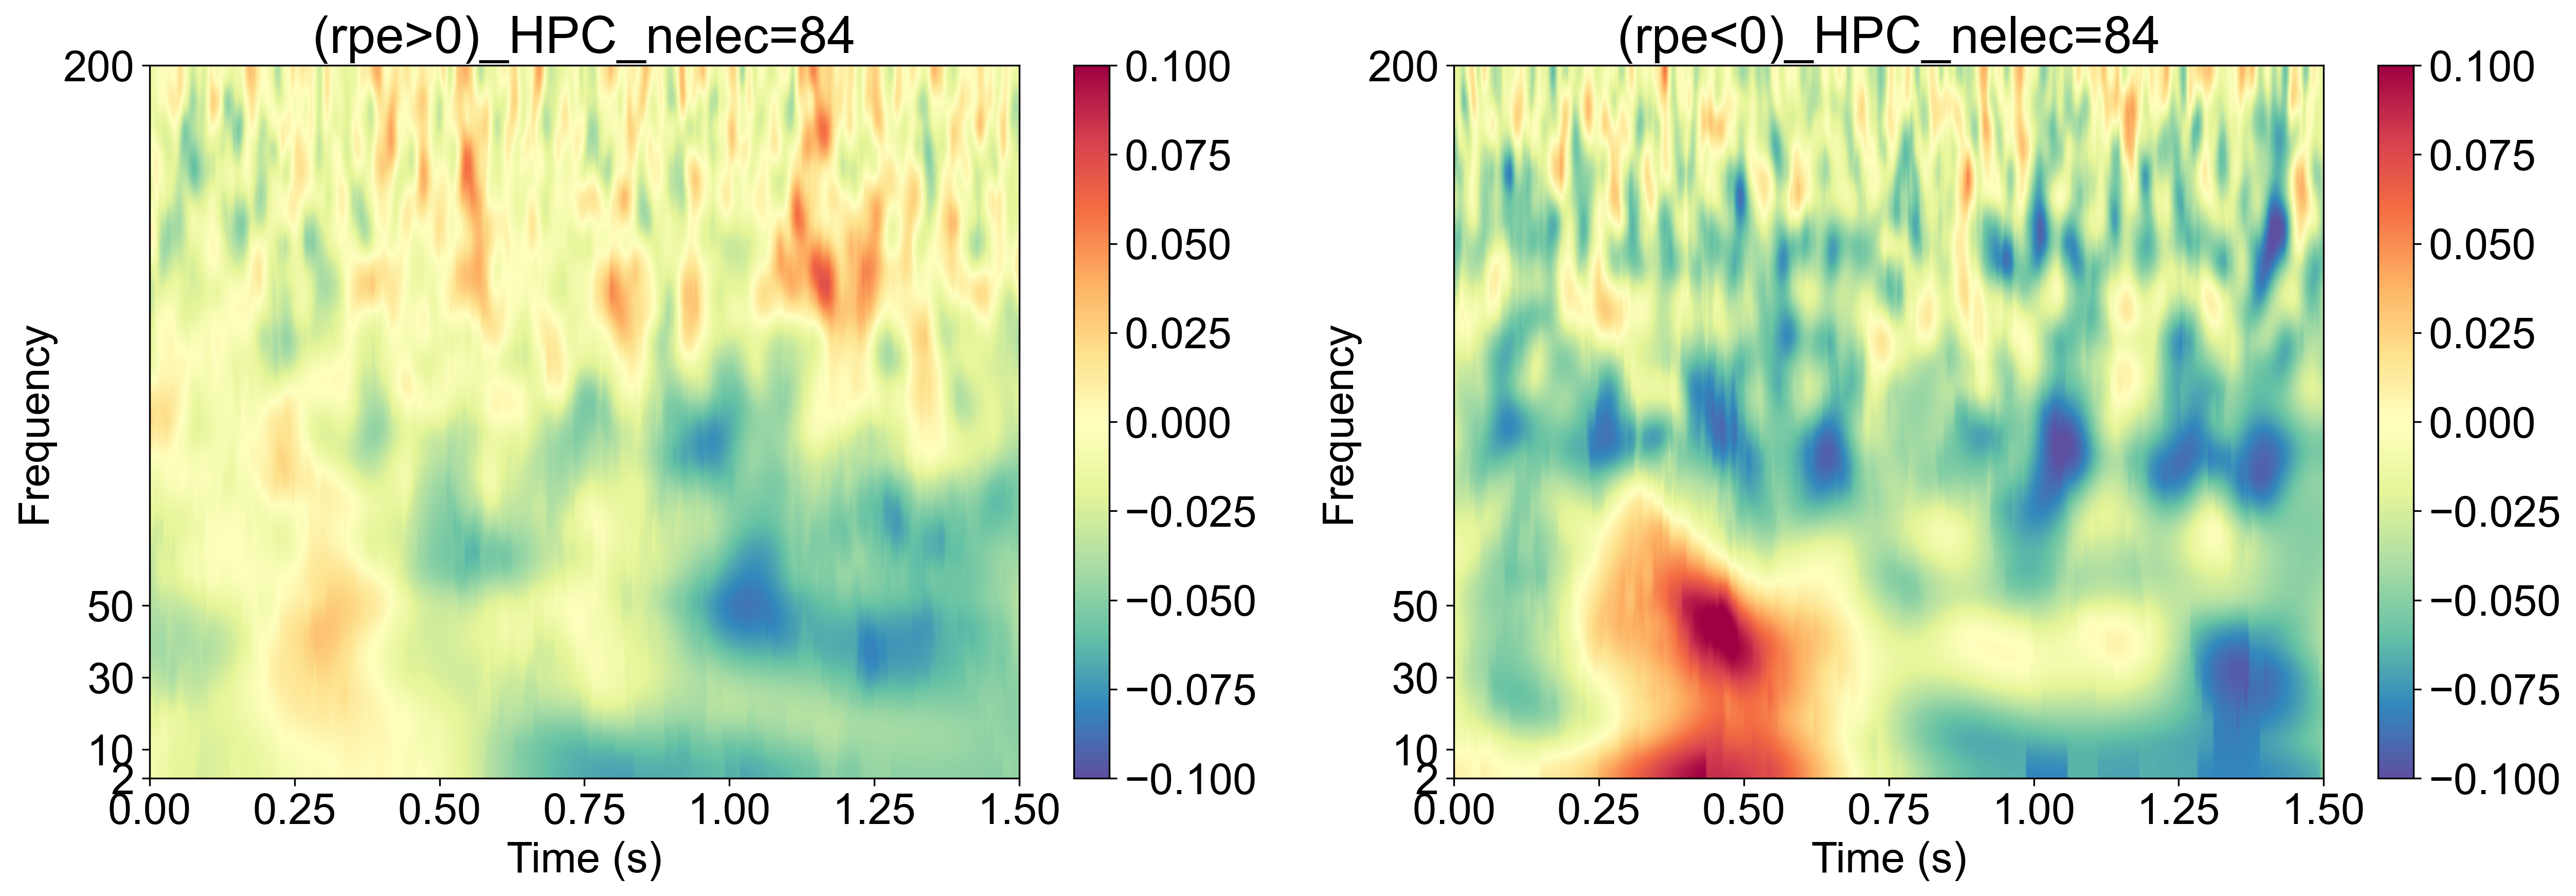

In [268]:
freqs = np.logspace(*np.log10([2, 200]), num=30)

for region in rois: 
    # if region == 'TC':
    #     region = (('Temporal') | ('Temporal Pole') | ('STS'))
    fig, ax = plt.subplots(1, 2, figsize=(20, 6), dpi=300)
    for ix, cond in enumerate(conditions): 
        # Set the times for 
        n_elecs = np.squeeze(np.stack(tfr_group_data[region][cond])).shape[0]
        times = np.linspace(0, 1.5, np.squeeze(np.stack(tfr_group_data[region][cond])).shape[2])

        plot_data = np.nanmean(np.squeeze(np.stack(tfr_group_data[region][cond])), axis=0)
                
        im = ax[ix].imshow(dat_[ch_, :, :],
                          aspect='auto', origin='lower', cmap='Spectral_r', interpolation = 'bicubic')            
        ax[ix].set(xlabel='Time (s)', ylabel='Frequency', title=f'{cond}_{region}_nelec={n_elecs}')

        # Set custom y-axis ticks and labels
        freq_res = 5
        time_res = 250 
        ax[ix].set(yticks=np.arange(0, len(freqs))[::freq_res], 
               yticklabels=freqs[::freq_res].astype(int), 
               xticks = np.arange(len(times))[::time_res],
               xticklabels= zpow.times[::time_res])

        fig.colorbar(im, ax=ax[ix])
        plt.savefig(f'/sc/arion/work/qasims01/MemoryBanditData/EMU/plots/feedback_TFR_{cond_name}_{region}.pdf', dpi=300)

        
        

In [250]:
freqs

array([  2.        ,   2.3442046 ,   2.74764759,   3.22052406,
         3.77478364,   4.42443258,   5.18588759,   6.07839076,
         7.12449578,   8.35063787,   9.78780184,  11.47230502,
        13.44671507,  15.76092563,  18.47341714,  21.65273468,
        25.37922006,  29.74704215,  34.86657644,  40.86719436,
        47.9005324 ,  56.14432408,  65.80689125,  77.13240842,
        90.40707313, 105.96633813, 124.20338838, 145.57907688,
       170.63357048, 200.        ])

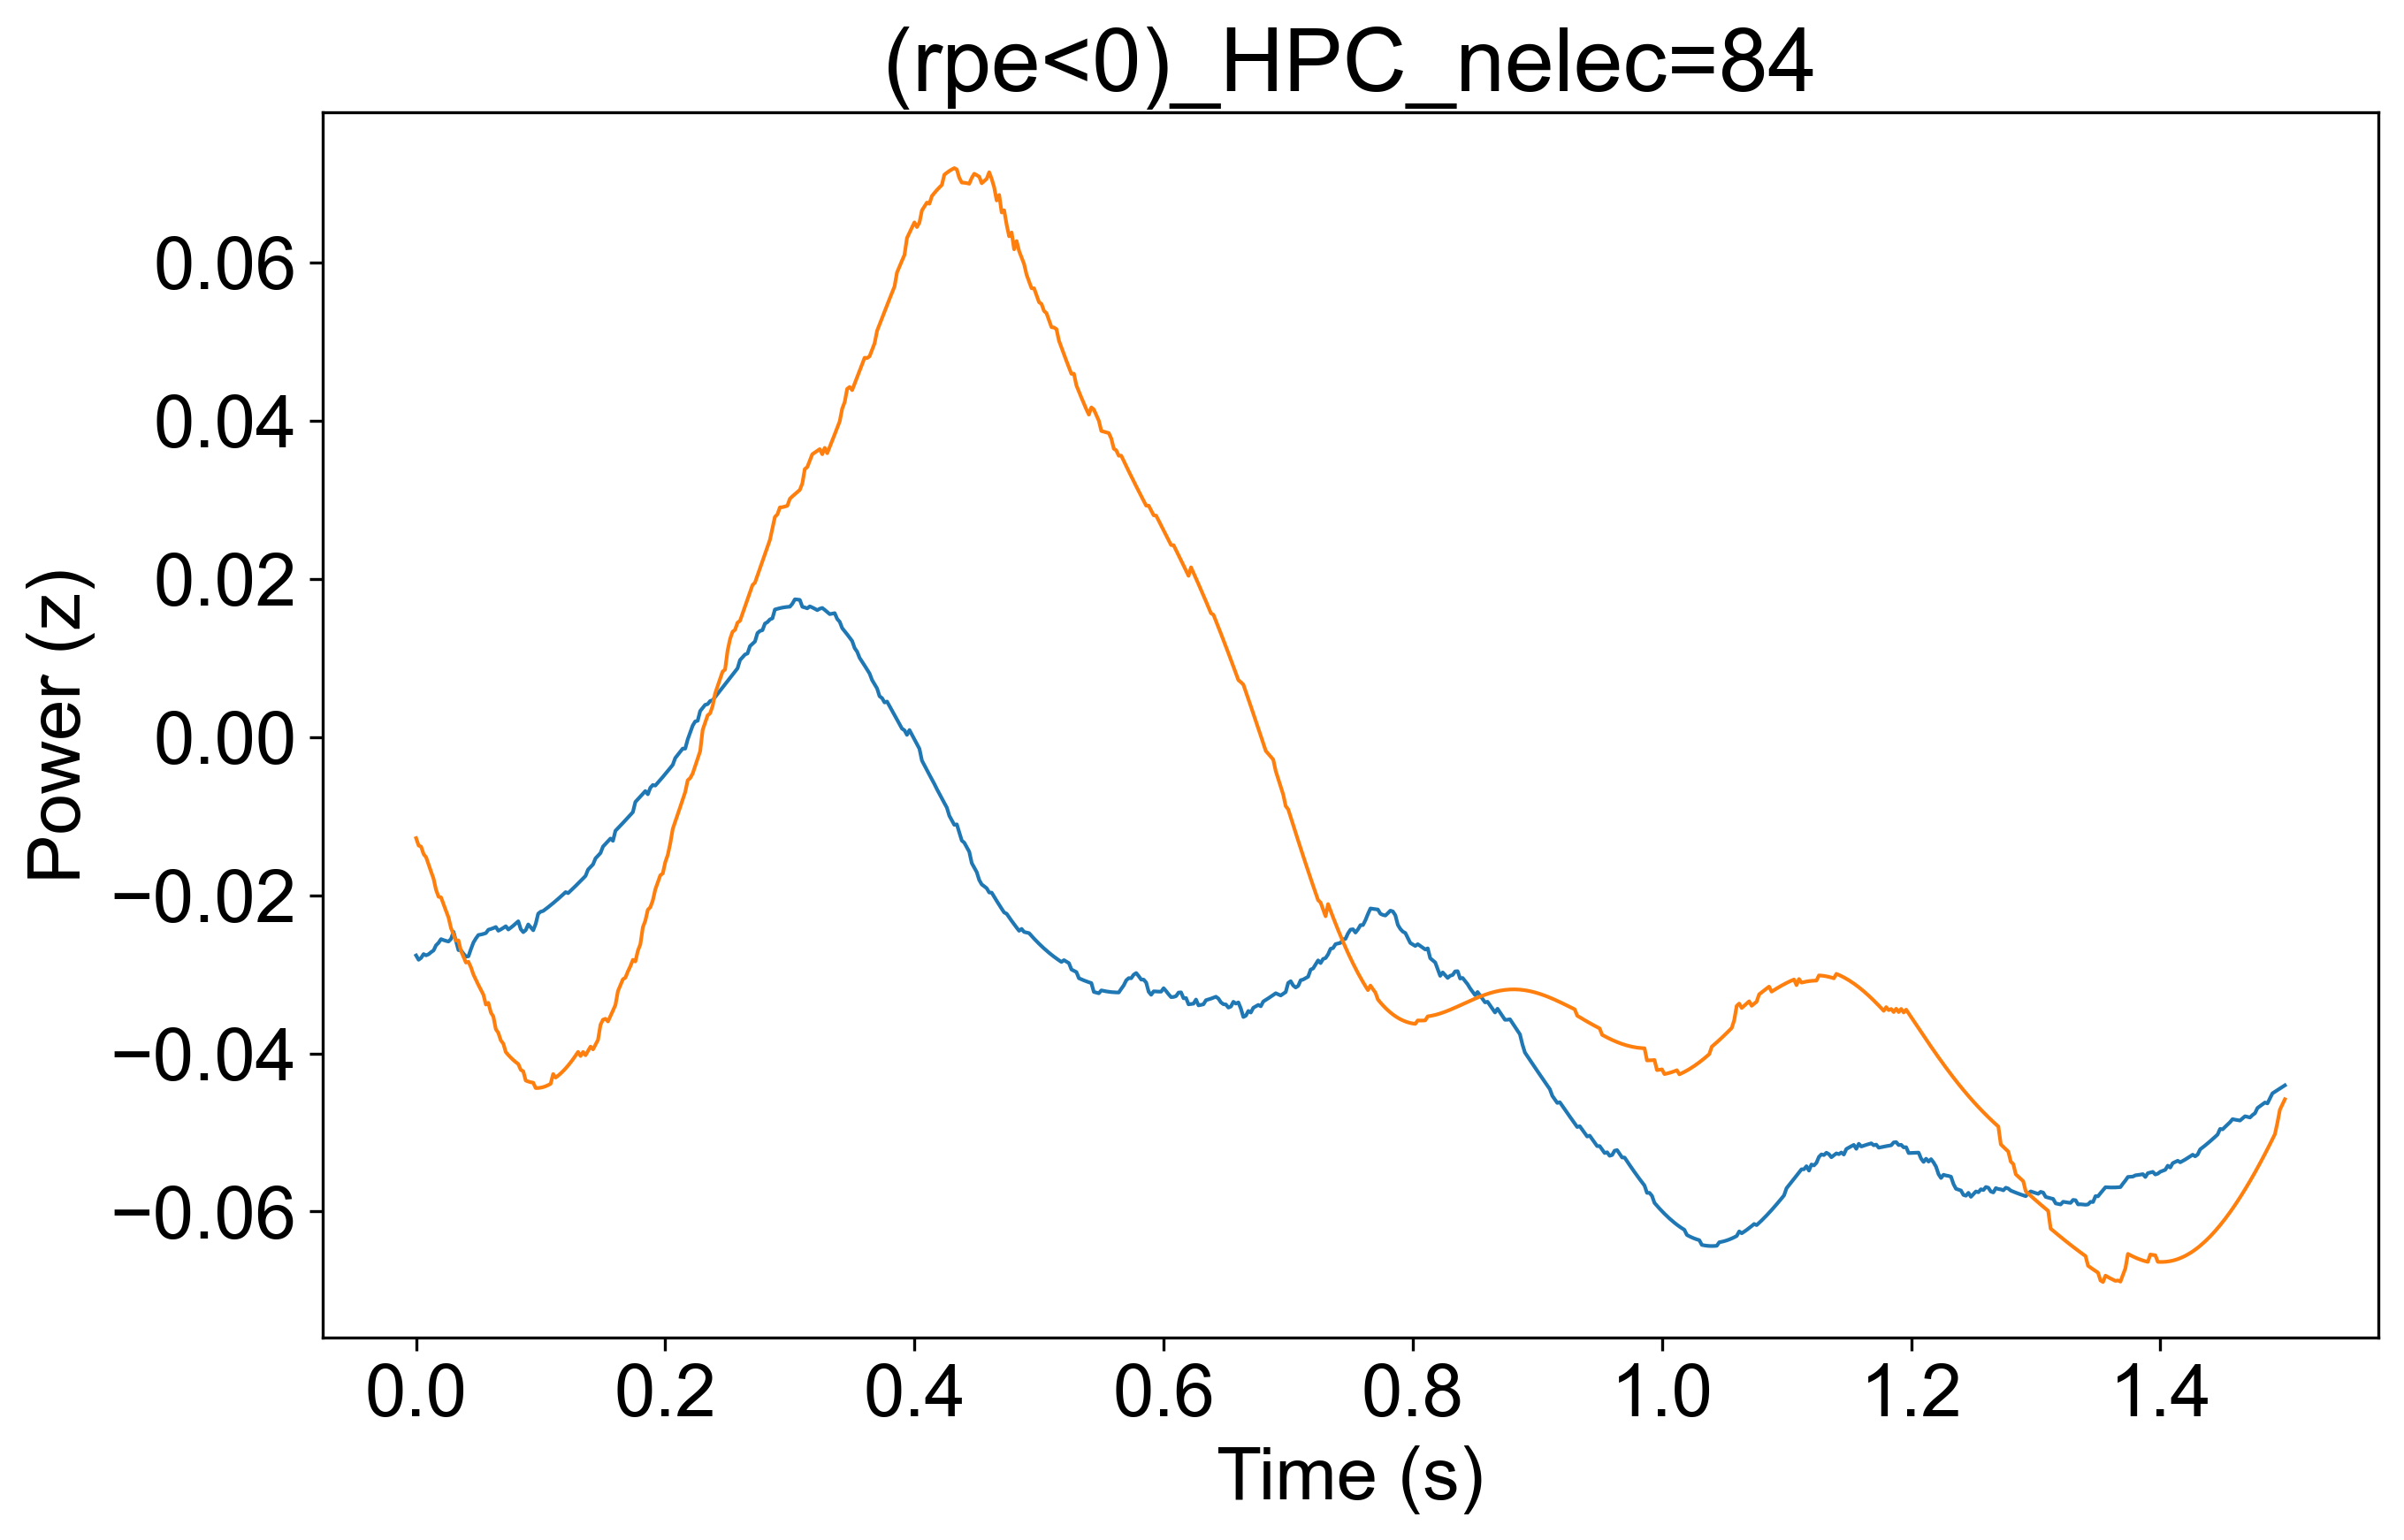

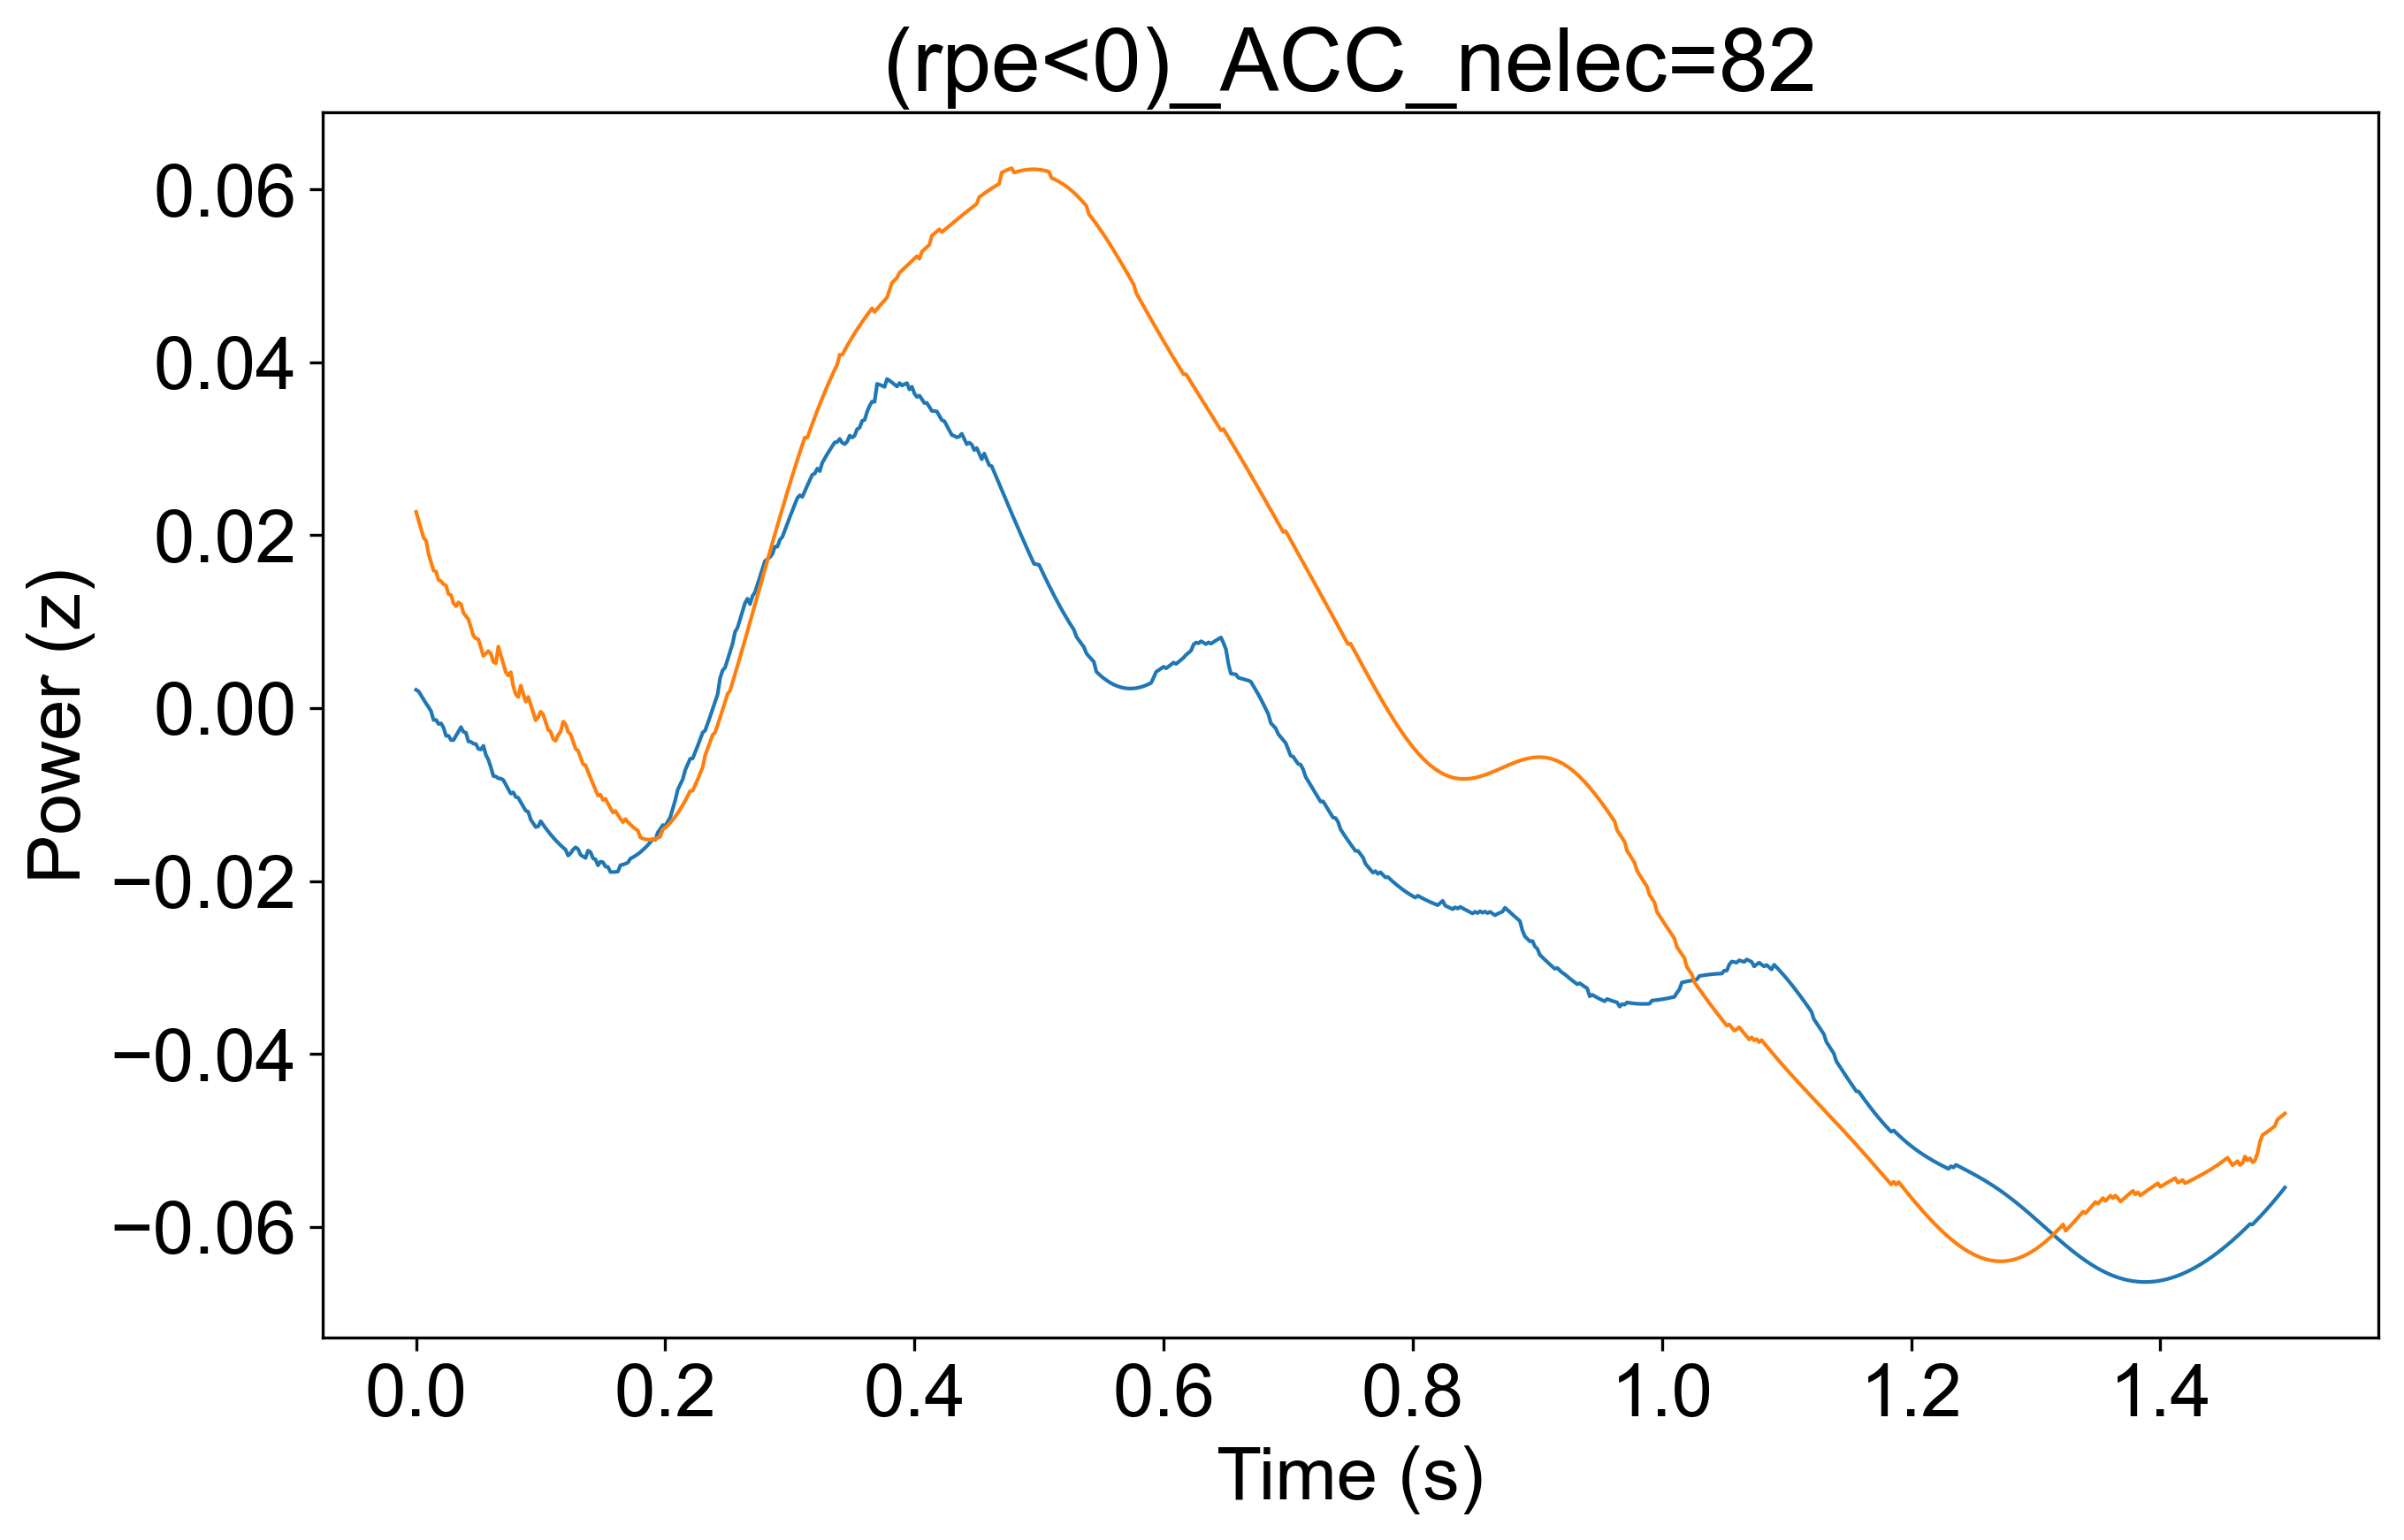

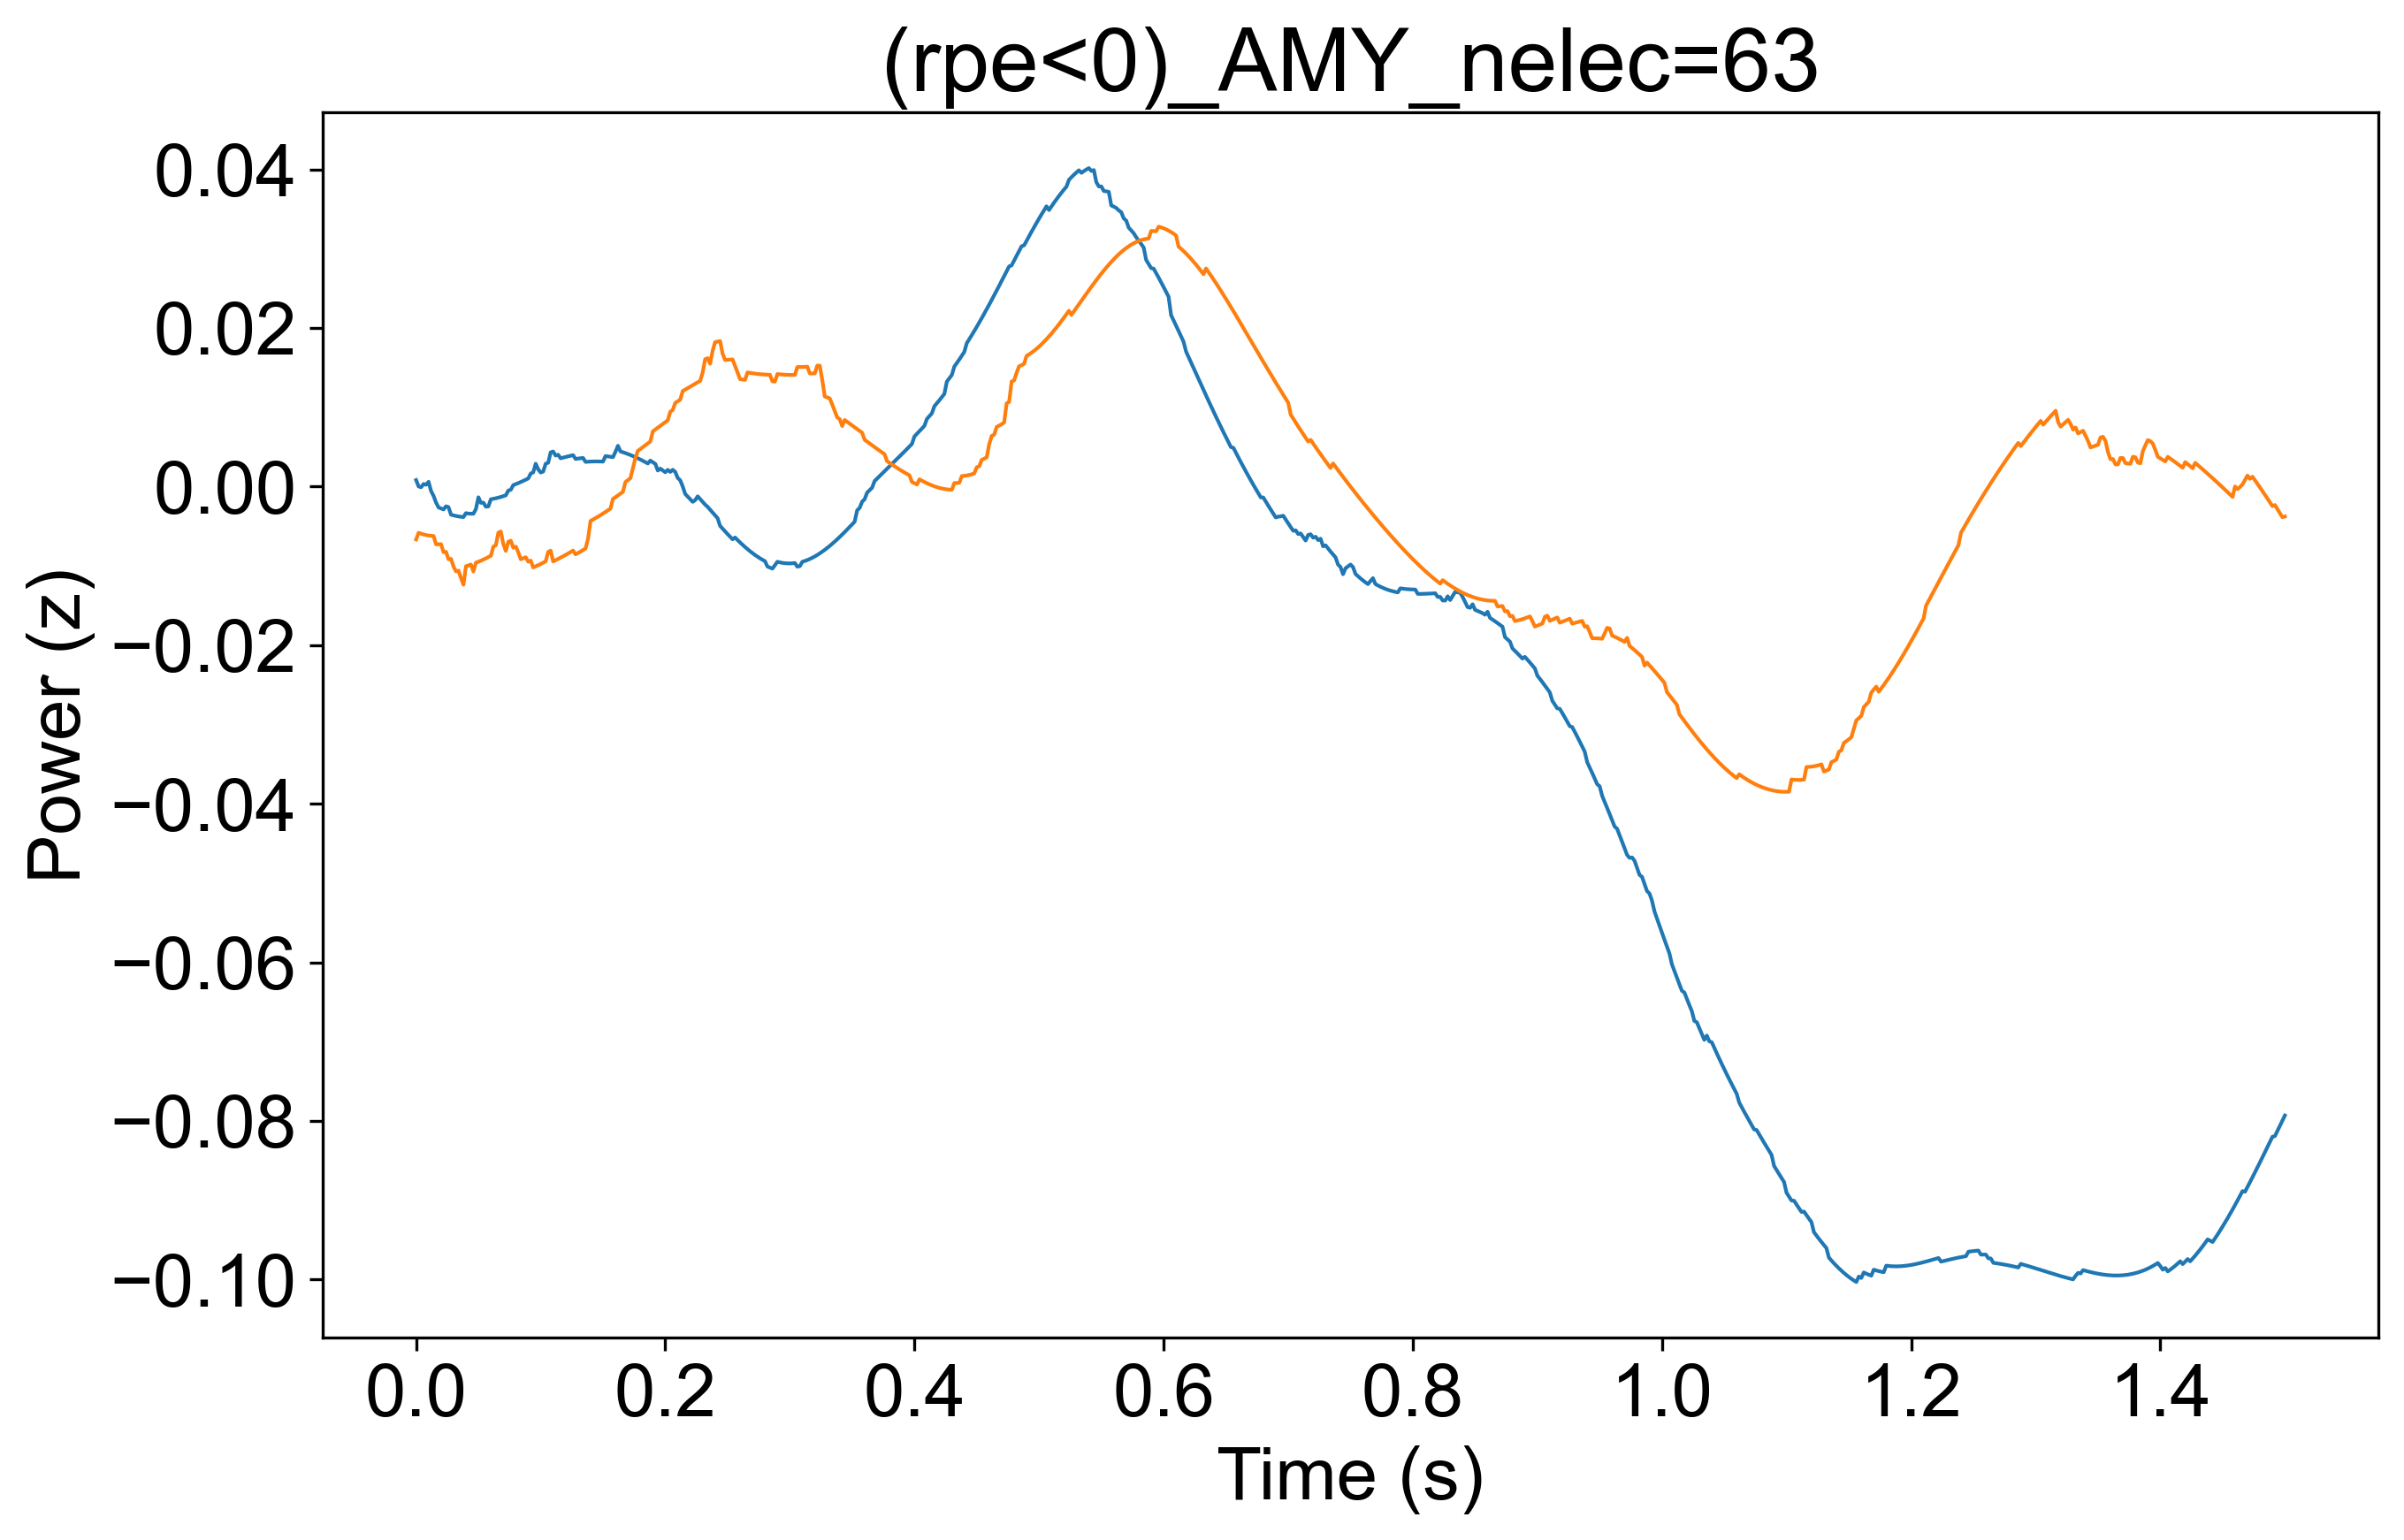

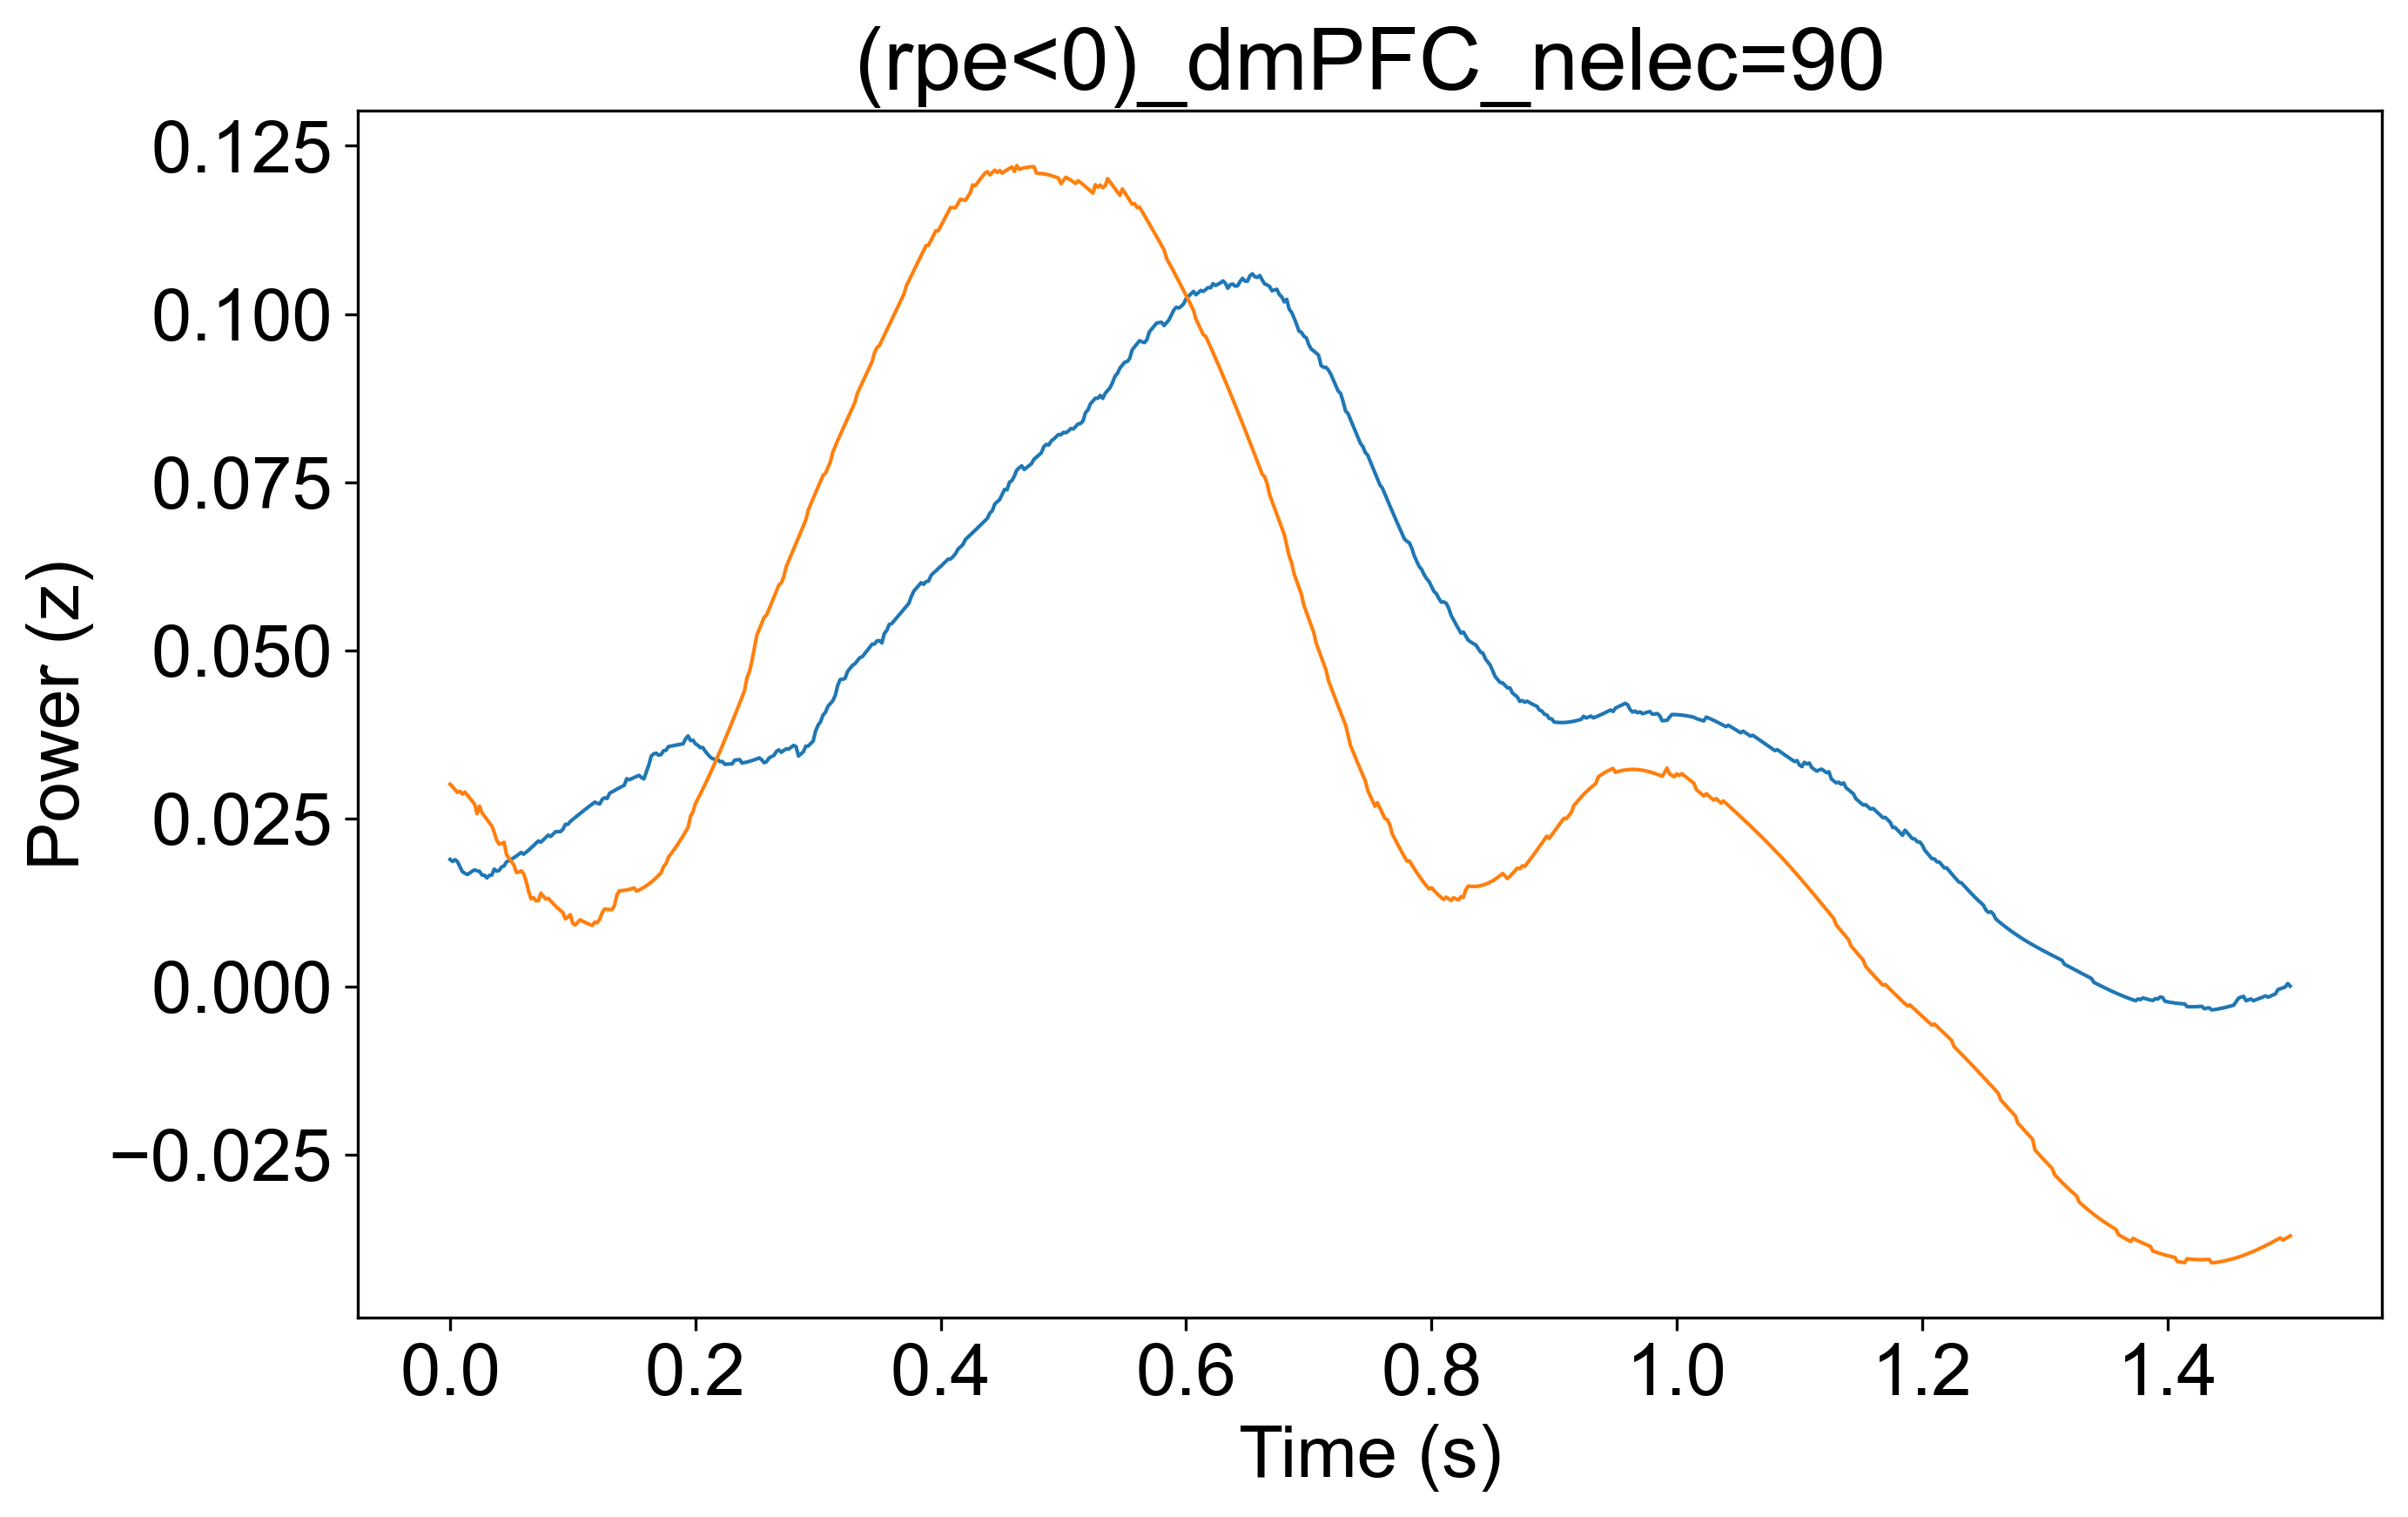

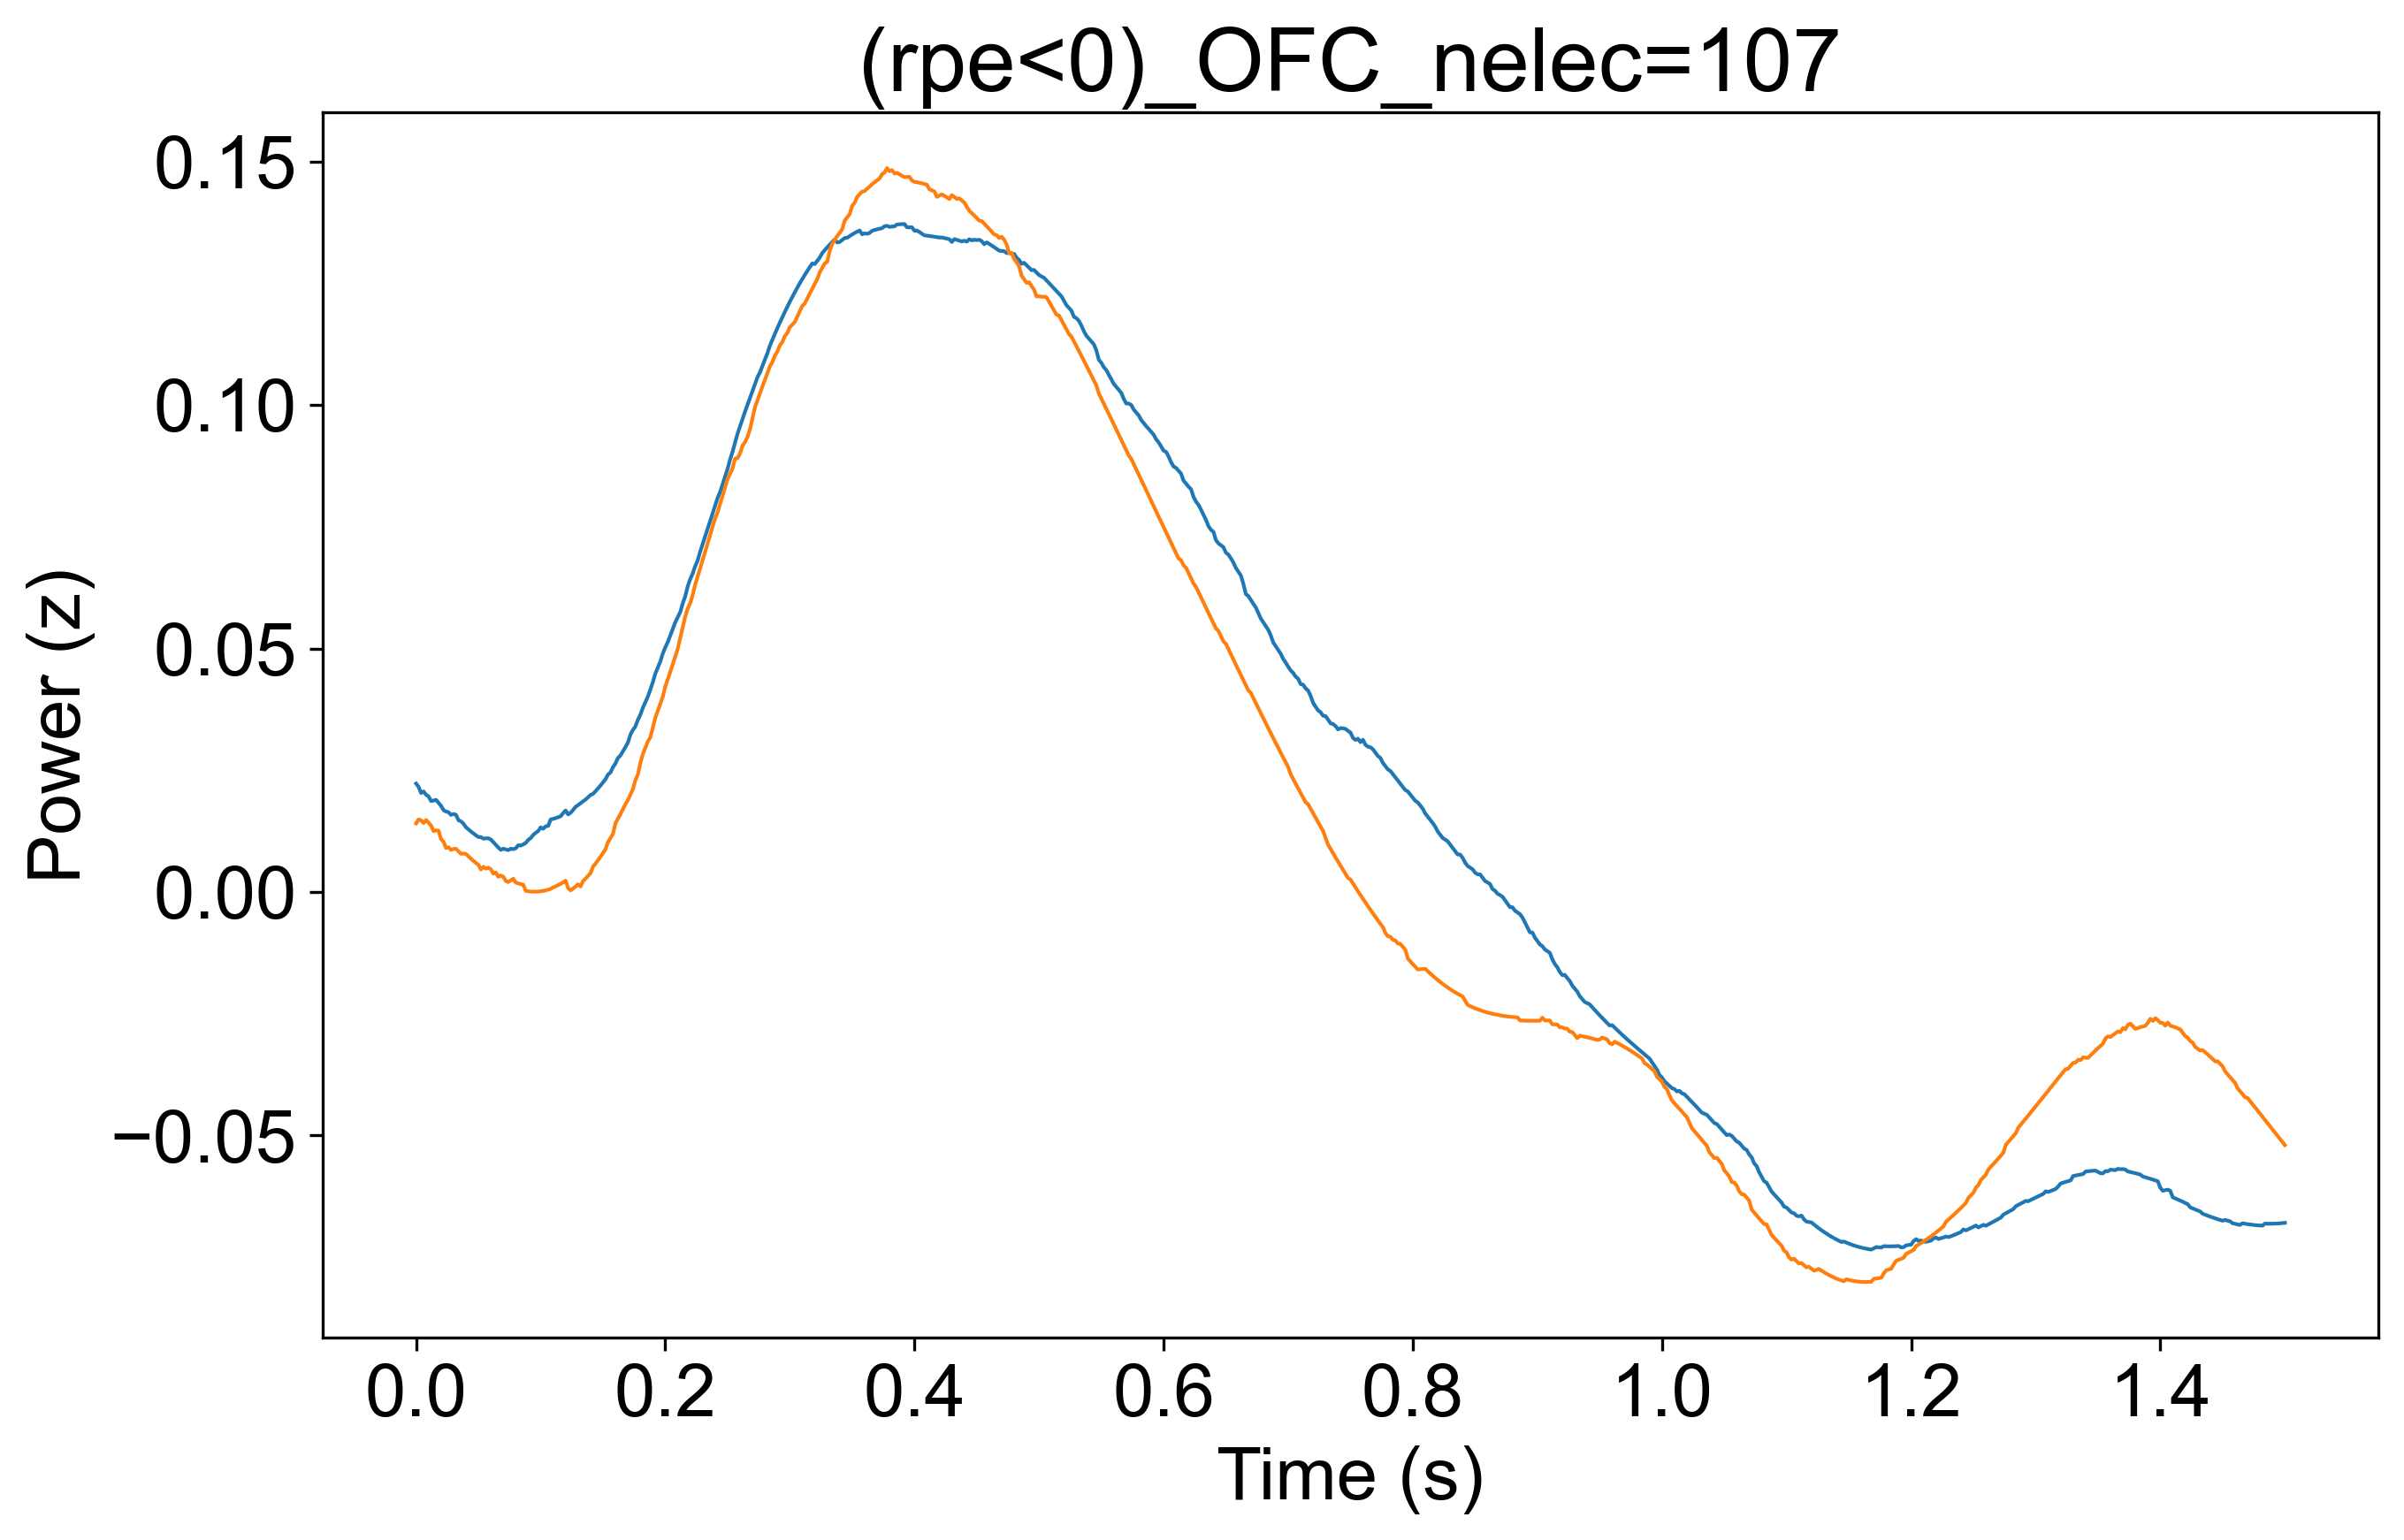

In [188]:
for region in rois: 
    # if region == 'TC':
    #     region = (('Temporal') | ('Temporal Pole') | ('STS'))
    fig, ax = plt.subplots(1, 1, figsize=(10, 6), dpi=300, sharey=True, sharex=True)
    for ix, cond in enumerate(conditions): 
        # Set the times for 
        n_elecs = np.squeeze(np.stack(tfr_group_data[region][cond])).shape[0]
        times = np.linspace(0, 1.5, np.squeeze(np.stack(tfr_group_data[region][cond])).shape[2])

#         if cond_name == 'SME':
#             plot_data = np.nanmedian(np.nanmedian(np.squeeze(np.stack(tfr_group_data[region][cond])), axis=0), axis=0)
#         else:
        plot_data = np.nanmean(np.squeeze(np.stack(tfr_group_data[region][cond])), axis=0)
        ax.plot(times, np.nanmean(plot_data[freqs<9, :], axis=0))
      
        ax.set(xlabel='Time (s)', ylabel='Power (z)', title=f'{cond}_{region}_nelec={n_elecs}')
        # fig.colorbar(im, ax=ax[ix])
        plt.savefig(f'/sc/arion/work/qasims01/MemoryBanditData/EMU/plots/feedback_theta_{cond_name}_{region}.pdf', dpi=300)


## Statistical Analyses of TFRs:

At this stage, you should **heavily** brainstorm the statistics you want to do, before you start writing any code. What is the goal of your analysis? What would actually allow you to show what you want to show?

Conduct the two-sample permutation test. This is most handy if your categories are naturally discrete, or helpful to bin. It is less good if you woud actually get statistical value from continuous stats.

In [154]:
# # freqs = np.logspace(*np.log10([4, 120]), num=30)

# # conditions = ['(rpe>0)',
# #              '(rpe<0)']
# # conditions = ['(rpe>0) & (hits==1)',
# #              '(rpe>0) & (hits==0)']

# cond_name = 'SME'
        
# # times = np.linspace(0, 1.5, np.stack(tfr_group_data[region][cond]).shape[2])
    
# for region in rois: 
#     # # Average the data in each condition across channels 
#     if 'SME' in cond_name:
#         X = [np.squeeze(np.vstack(tfr_group_data[region][conditions[0]])),
#              np.squeeze(np.vstack(tfr_group_data[region][conditions[1]]))]
#     else:
#         X = [np.stack(tfr_group_data[region][conditions[0]]), 
#              np.stack(tfr_group_data[region][conditions[1]])]
        
#     F_obs, clusters, cluster_p_values, H0 = \
# mne.stats.permutation_cluster_test(X, n_permutations=1000, out_type='mask', verbose=True,
#                                    threshold=6,
#                                    seed=1, n_jobs=1, tail=0)
    
#     # Create new stats image with only significant clusters
#     fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=300)
    
#     # Average the data in each condition across epochs for plotting
#     evoked_power_1 = np.nanmean(X[0], axis=0)
#     evoked_power_2 = np.nanmean(X[1], axis=0)
#     evoked_power_contrast = evoked_power_1 - evoked_power_2
#     signs = np.sign(evoked_power_contrast)

#     F_obs_plot = np.nan * np.ones_like(F_obs)
#     for c, p_val in zip(clusters, cluster_p_values):
#         if p_val <= 0.05:
#             F_obs_plot[c] = F_obs[c] * signs[c]

#     ax.imshow(F_obs,
#               extent=[times[0], times[-1], freqs[0], freqs[-1]],
#               aspect='auto', origin='lower', cmap='Spectral_r', alpha =0.55)
#     max_F = np.nanmax(abs(F_obs_plot))
#     c= ax.imshow(F_obs_plot,
#               extent=[times[0], times[-1], freqs[0], freqs[-1]],
#               aspect='auto', origin='lower', cmap='Spectral_r',
#               vmin=-max_F, vmax=max_F)

#     ax.set(yticks=yticks, xlabel='Time (s)', ylabel='Frequency', title=f'{region}_{cond_name}')
#     fig.colorbar(c, ax=ax)
#     plt.savefig(f'/sc/arion/work/qasims01/MemoryBanditData/EMU/plots/feedback_clustperm_{cond_name}_{region}.pdf', dpi=300)


## One-sample cluster permutation test


A one sample cluster permutation test measures whether a spectrogram differs significantly from a particular mean (typically 0). 

  0%|          | Permuting : 0/499 [00:00<?,       ?it/s]

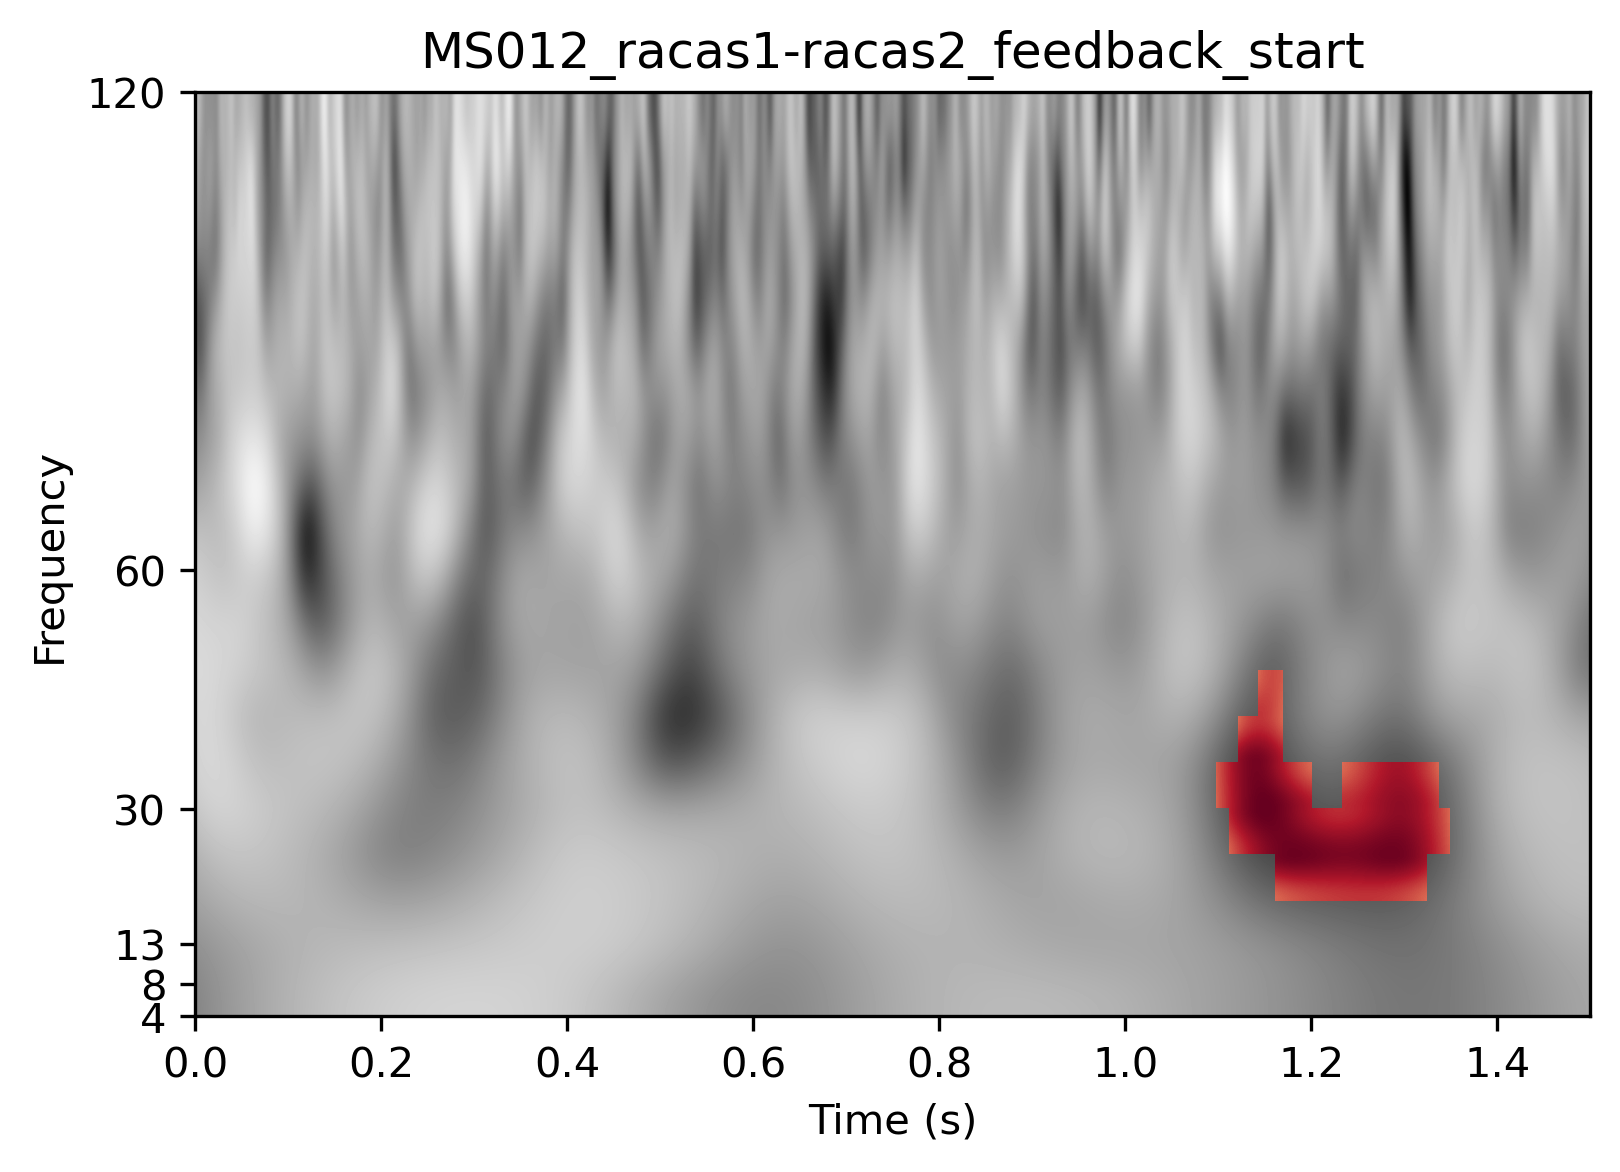

In [66]:
subj_id = 'MS012'
# region = 'frontal'

# save_path = f'{base_dir}/projects/guLab/Salman/EphysAnalyses/{subj_id}'
# # Get electrode df 
# elec_path = f'{base_dir}/projects/guLab/Salman/EMU/{subj_id}/anat/'
# # electrode files could either be csv or excel
# elec_files = glob(f'{elec_path}/*.csv') + glob(f'{elec_path}/*.xlsx')
# # There should really only be one 
# elec_file = elec_files[0]
# elec_data = lfp_preprocess_utils.load_elec(elec_file)

# anode_list = [x.split('-')[0] for x in epochs_all_subjs_all_evs[subj_id][event].ch_names]
# elec_df = elec_data[elec_data.label.str.lower().isin(anode_list)]
# # Shawn noticed the following would incorrectl y label electrodes if they're not in the same order as .ch_names! 
# # elec_df['label'] = epochs_all_subjs_all_evs[subj_id][event].ch_names
# # Fix: 
# elec_df['label'] = elec_df['label'].apply(lambda x: next((string for string in epochs_all_subjs_all_evs[subj_id][event].ch_names if x in string), np.nan))
    
# picks = analysis_utils.select_picks_rois(elec_df, region)

for event in analysis_evs:
    
    # Average the data in each condition across channels 
    X = np.nanmean(power_epochs[subj_id][event].copy().pick_channels([chan]).data, axis=1)
    
    F_obs, clusters, cluster_p_values, H0 = \
    mne.stats.permutation_cluster_1samp_test(X, n_permutations=500, out_type='mask', verbose=True)
    
    if any(cluster_p_values<=0.05):
#     print(region)
        # Create new stats image with only significant clusters
        fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=300)

        times =  power_epochs[subj_id][event].times


        # Average the data in each condition across epochs for plotting
        evoked_power = np.nanmean(X, axis=0)
    #     evoked_power_2 = np.nanmean(X[1], axis=0)
    #     evoked_power_contrast = evoked_power_1 - evoked_power_2
        signs = np.sign(evoked_power)

        F_obs_plot = np.nan * np.ones_like(F_obs)
        for c, p_val in zip(clusters, cluster_p_values):
            if p_val <= 0.05:
                F_obs_plot[c] = F_obs[c] * signs[c]

        ax.imshow(F_obs,
                  extent=[times[0], times[-1], freqs[0], freqs[-1]], interpolation = 'Bicubic',
                  aspect='auto', origin='lower', cmap='gray')
        max_F = np.nanmax(abs(F_obs_plot))
        ax.imshow(F_obs_plot,
                  extent=[times[0], times[-1], freqs[0], freqs[-1]],
                  aspect='auto', origin='lower', cmap='RdBu_r',
                  vmin=-max_F, vmax=max_F)

        ax.set(yticks=yticks, xlabel='Time (s)', ylabel='Frequency', title=f'{subj_id}_{chan}_{event}')

            # # ax.set_title(f'Induced power ({ch_name})')
    
    